# Demo: Axisymmetric Poisson solver with pure dirichlet boundary conditions

Reference

- https://onlinelibrary.wiley.com/doi/pdf/10.1002/cnm.1630030603?saml_referrer

Problem description

$$
\nabla^2 \Phi(r, z) = -4 r^2 e^{-2z},
$$

where the boundary conditions are

$$
\Phi(0, z) = e^{-2z}, \Phi(1, z) = 0, \\ \Phi(r, 0) = 1 - r^2,~\text{and}~\Phi(r, 2) = e^{-4}(1-r^2).
$$

The exact solution of this problem is given by $\Phi(r, z) = e^{-2z}(1-r^2)$.


In [1]:
from pyapes.core.geometry import Cylinder
from pyapes.core.mesh import Mesh
from pyapes.core.solver.fdm import FDM
from pyapes.core.solver.ops import Solver
from pyapes.core.variables import Field
from pyapes.core.variables.bcs import CylinderBoundary
import torch
from torch import Tensor

# Construct mesh with nx = 64
mesh = Mesh(Cylinder[0:1, 0:2], None, [64, 64])

def bc_ru(grid: tuple[Tensor, ...], mask: Tensor, *_) -> Tensor:
    return torch.zeros_like(grid[0][mask])

def bc_zl(grid: tuple[Tensor, ...], mask: Tensor, *_) -> Tensor:
    return 1 - grid[0][mask]**2

def bc_zu(grid: tuple[Tensor, ...], mask: Tensor, *_) -> Tensor:
    return torch.exp(-2.0*grid[1][mask])*(1 - grid[0][mask])

f_bc = CylinderBoundary(
    rl={"bc_type": "neumann", "bc_val": 0.0},
    ru={"bc_type": "dirichlet", "bc_val": bc_ru},
    zl={"bc_type": "dirichlet", "bc_val": bc_zl},
    zu={"bc_type": "dirichlet", "bc_val": bc_zu},
)

# Target variable
var = Field("p", 1, mesh, {"domain": f_bc(), "obstacle": None})

solver = Solver(
        {
            "fdm": {
                "method": "bicgstab",
                "tol": 1e-5,
                "max_it": 1000,
                "report": True,
            }
        }
    )
fdm = FDM()

sol_ex = torch.exp(-2.0*mesh.Z) * (1 - mesh.R**2)

rhs = torch.zeros_like(var())
rhs[0] = - 4.0 * mesh.R**2 * torch.exp(-2.0*mesh.Z)

solver.set_eq(fdm.laplacian(1.0, var) == rhs)
solver.solve()



BICGSTAB: The solution  converged after 168 iteration.
	tolerance: 9.965326924733043e-06


{'itr': 168, 'tol': 9.965326924733043e-06, 'converge': True}

Comparison to the exact solution:

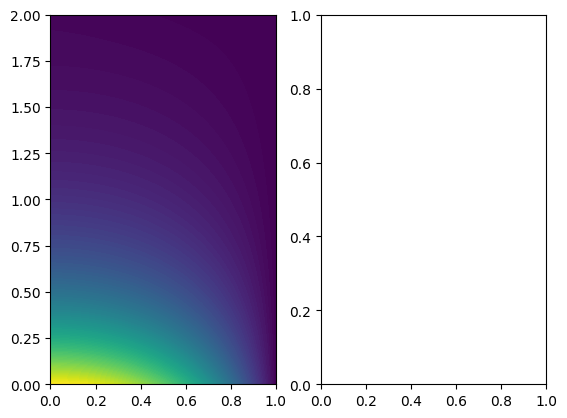

In [3]:
from pymyplot import myplt as plt
from pymyplot.colors import get_cmap

_, ax = plt.subplots(1, 2)
ax[0].contourf(mesh.R, mesh.Z, var()[0], 100, cmap=get_cmap("sunset"))